In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [83]:
import findspark
findspark.init()

In [84]:
#Creating Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("PySpark").getOrCreate()

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("cybersecurity_salary_prediction").getOrCreate()
data = spark.read.csv("/content/drive/MyDrive/9th Semester/Big Data/Project/salaries.csv", header=True, inferSchema=True)
data.show(5)

+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|work_year|experience_level|employment_type|           job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|
+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|     2023|              EX|             FT|Information Secur...|160000|            USD|       160000|                US|         100|              US|           M|
|     2023|              EX|             FT|Information Secur...|100000|            USD|       100000|                US|         100|              US|           M|
|     2023|              SE|             FT|   Security Engineer|247250|            USD|       247250|                US|           0|              US|           M|
|     2023

Getting Column Names

In [87]:
colNames = data.columns
colNames

['work_year',
 'experience_level',
 'employment_type',
 'job_title',
 'salary',
 'salary_currency',
 'salary_in_usd',
 'employee_residence',
 'remote_ratio',
 'company_location',
 'company_size']

In [94]:
from pyspark.sql.functions import col, when, count, isnull
# Checking for missing values
data.select([count(when(isnull(c), c)).alias(c) for c in data.columns]).show()

+---------+----------------+---------------+---------+------+---------------+-------------+------------------+------------+----------------+------------+
|work_year|experience_level|employment_type|job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|
+---------+----------------+---------------+---------+------+---------------+-------------+------------------+------------+----------------+------------+
|        0|               0|              0|        0|     0|              0|            0|                 0|           0|               0|           0|
+---------+----------------+---------------+---------+------+---------------+-------------+------------------+------------+----------------+------------+



Aggregation Operations

In [88]:
from pyspark.sql.functions import avg, sum, max
avg_res = data.select(avg("salary_in_usd")).first()[0]
sum_res = data.select(sum("salary_in_usd")).first()[0]
max_res = data.select(max("salary_in_usd")).first()[0]
print(avg_res, sum_res, max_res)

145772.43101532993 656121712 456621


Sorting By a Column

In [14]:
sorted_by_rooms = data.orderBy("salary_in_usd")
sorted_by_rooms.show()

+---------+----------------+---------------+--------------------+-------+---------------+-------------+------------------+------------+----------------+------------+
|work_year|experience_level|employment_type|           job_title| salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|
+---------+----------------+---------------+--------------------+-------+---------------+-------------+------------------+------------+----------------+------------+
|     2022|              MI|             FT| Security Consultant|1250000|            INR|        15897|                IN|           0|              IN|           L|
|     2021|              EN|             FT|Application Secur...|1200000|            INR|        16228|                IN|           0|              IN|           L|
|     2023|              EN|             PT|Cloud Cyber Secur...| 300000|            ZAR|        16498|                ZA|          50|              ZA|           L|
|   

Statistical Opeartions

In [18]:
from pyspark.sql.functions import mean, stddev
mean_res = data.select(mean("salary_in_usd")).first()[0]
std_res = data.select(stddev("salary_in_usd")).first()[0]
print(mean_res, std_res)

137331.99548241368 64924.26332277094


In [89]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

duplicate_rows = data.groupBy(data.columns).count().filter(col("count") > 1)

columns_to_check = ["work_year", "experience_level", "employment_type", "job_title", "salary", "salary_currency", "salary_in_usd", "employee_residence",
                     "remote_ratio", "company_location", "company_size"]

# Find duplicate rows based on all columns
duplicate_count = data.groupBy(data.columns).count().filter(col("count") > 1).count()

# Show the total count of duplicate rows
print(f"Total count of duplicate rows: {duplicate_count}")

data_no_duplicates = data.dropDuplicates()

duplicate_count = data_no_duplicates.groupBy(data.columns).count().filter(col("count") > 1).count()

# Show the total count of duplicate rows
print(f"Total count of duplicate rows: {duplicate_count}")

Total count of duplicate rows: 516
Total count of duplicate rows: 0


In [20]:
data = data_no_duplicates

In [21]:
# Display descriptive statistics for numeric columns
data_summary_numeric = data.summary()
data_summary_numeric.show()

# Display descriptive statistics for string columns
data_summary_string = data.summary("mean", "stddev", "min", "25%", "50%", "75%", "max")
data_summary_string.show()

+-------+------------------+----------------+---------------+--------------------+-----------------+---------------+------------------+------------------+------------------+----------------+------------+
|summary|         work_year|experience_level|employment_type|           job_title|           salary|salary_currency|     salary_in_usd|employee_residence|      remote_ratio|company_location|company_size|
+-------+------------------+----------------+---------------+--------------------+-----------------+---------------+------------------+------------------+------------------+----------------+------------+
|  count|              3099|            3099|           3099|                3099|             3099|           3099|              3099|              3099|              3099|            3099|        3099|
|   mean| 2022.247176508551|            null|           null|                null|320507.1936108422|           null|137331.99548241368|              null|54.469183607615356|           

The ratio of work experience and salary

In [22]:
# Select specific columns
data_sub = data.select("work_year", "salary_in_usd", "experience_level")

# Show the first 10 rows
data_sub.show(10)

+---------+-------------+----------------+
|work_year|salary_in_usd|experience_level|
+---------+-------------+----------------+
|     2023|       340000|              EX|
|     2023|       132000|              SE|
|     2023|       130000|              SE|
|     2023|        55878|              SE|
|     2023|       247500|              MI|
|     2023|       250000|              EX|
|     2023|       150000|              SE|
|     2023|       169036|              SE|
|     2022|       250000|              SE|
|     2022|       210000|              SE|
+---------+-------------+----------------+
only showing top 10 rows



In [23]:
# Select specific columns
data_sub = data.select("work_year", "salary_in_usd", "experience_level")

# Group by 'experience_level' and calculate the mean of 'salary_in_usd'
salary_exp = data_sub.groupBy("experience_level").agg(avg("salary_in_usd").alias("mean_salary"))

# Show the first 10 rows
salary_exp.show(10)

+----------------+------------------+
|experience_level|       mean_salary|
+----------------+------------------+
|              EX|198811.38068181818|
|              MI|109533.25531914894|
|              EN| 76135.68238993711|
|              SE|154414.63621262458|
+----------------+------------------+



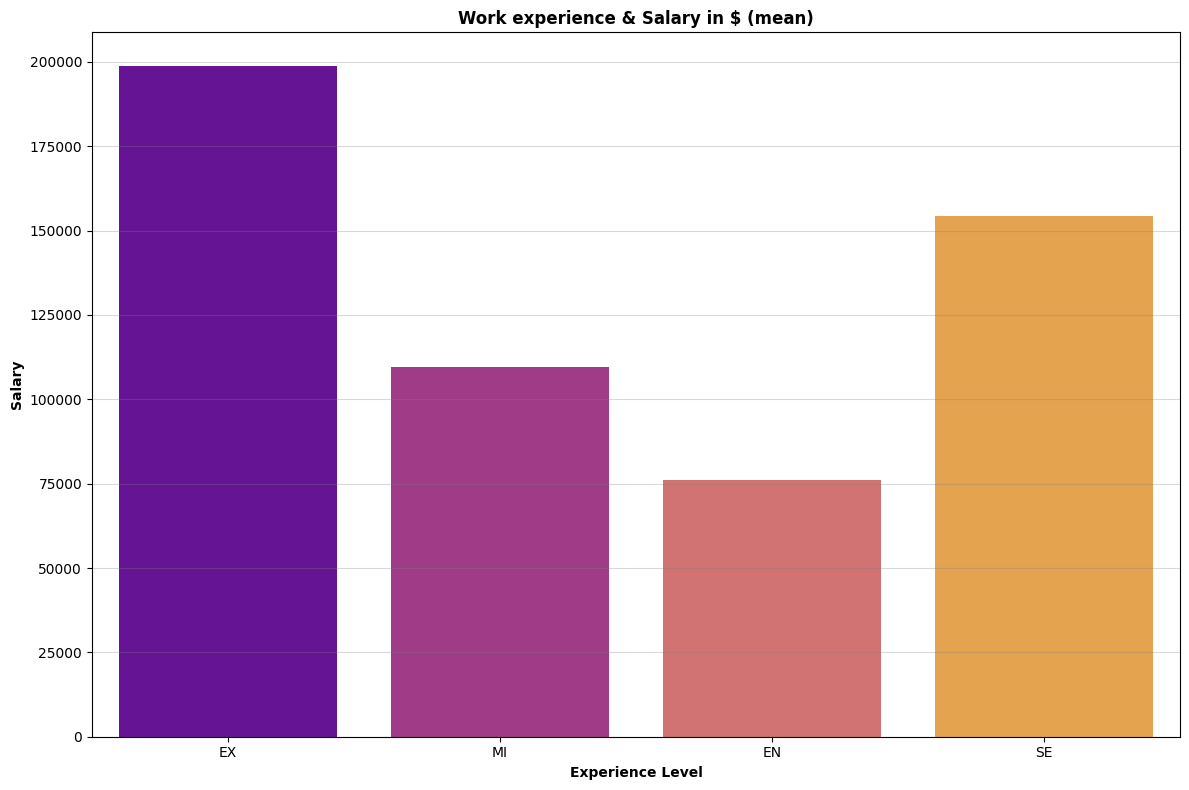

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#Select specific columns
data_sub = data.select("work_year", "salary_in_usd", "experience_level")

# Group by 'experience_level' and calculate the mean of 'salary_in_usd'
salary_exp = data_sub.groupBy("experience_level").agg(avg("salary_in_usd").alias("mean_salary"))

# Convert the Spark DataFrame to a Pandas DataFrame for local plotting
salary_exp_pd = salary_exp.toPandas()

# Plotting with matplotlib
plt.figure(figsize=(12, 8))
#plt.bar(salary_exp_pd['experience_level'], salary_exp_pd['mean_salary'], color='green')
sns.barplot(x = salary_exp_pd['experience_level'], y = salary_exp_pd['mean_salary'], palette = 'plasma')

plt.title('Work experience & Salary in $ (mean)', fontweight='bold')
plt.xlabel('Experience Level', fontweight='bold')
plt.ylabel('Salary', fontweight='bold')

plt.grid(True, axis='y', color='grey', alpha=0.3)

plt.tight_layout()
plt.show()


In [25]:
salary_exp.show()


+----------------+------------------+
|experience_level|       mean_salary|
+----------------+------------------+
|              EX|198811.38068181818|
|              MI|109533.25531914894|
|              EN| 76135.68238993711|
|              SE|154414.63621262458|
+----------------+------------------+



In [26]:
from pyspark.ml.feature import StringIndexer

# Assuming 'experience_level' is a string column in 'salary_exp'
string_indexer = StringIndexer(inputCol="experience_level", outputCol="experience_level_encoded")

# Fit and transform the DataFrame
salary_exp_encoded = string_indexer.fit(salary_exp).transform(salary_exp)

# Show the DataFrame with the encoded column
salary_exp_encoded.show()

+----------------+------------------+------------------------+
|experience_level|       mean_salary|experience_level_encoded|
+----------------+------------------+------------------------+
|              EX|198811.38068181818|                     1.0|
|              MI|109533.25531914894|                     2.0|
|              EN| 76135.68238993711|                     0.0|
|              SE|154414.63621262458|                     3.0|
+----------------+------------------+------------------------+



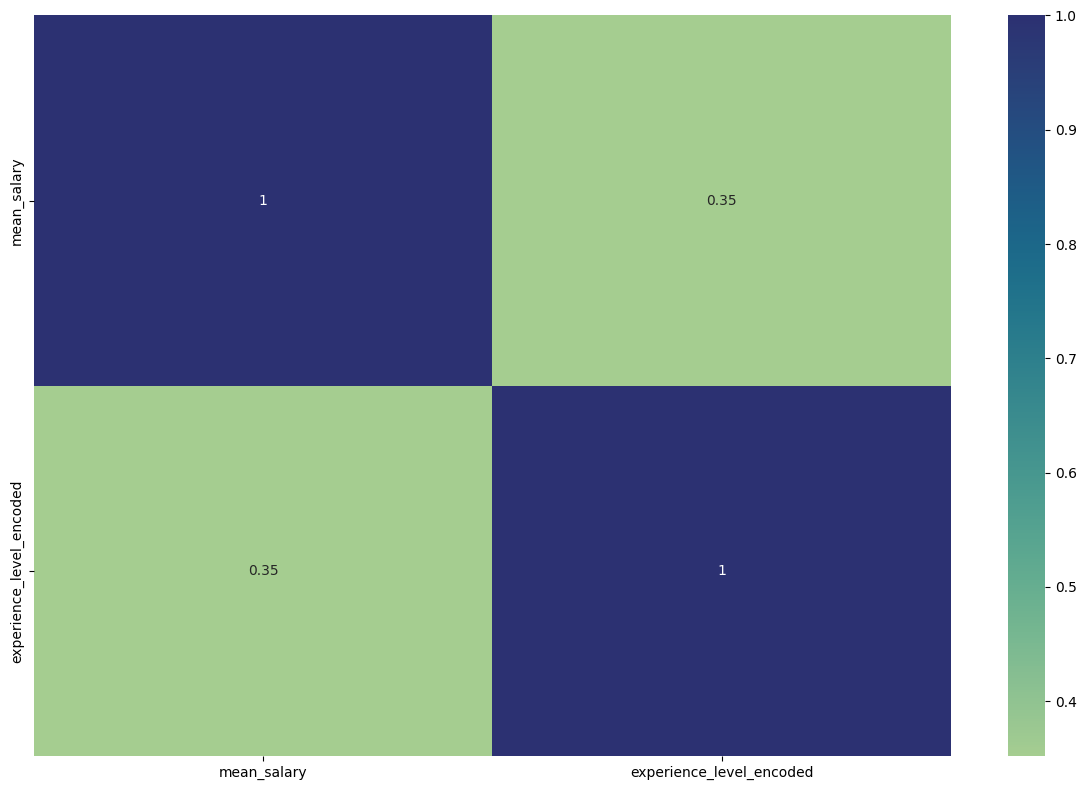

In [27]:
salary_exp_encoded_pd = salary_exp_encoded.toPandas()

plt.figure(figsize = (12,8))
sns.heatmap(salary_exp_encoded_pd.corr(numeric_only = True), annot = True, cmap = 'crest')

plt.tight_layout()
plt.show()

Overall correlation


In [28]:
data.show(10)

+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|work_year|experience_level|employment_type|           job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|
+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|     2023|              EX|             FT|   Security Engineer|340000|            USD|       340000|                US|           0|              US|           M|
|     2023|              SE|             FT|  Penetration Tester|132000|            USD|       132000|                US|         100|              US|           S|
|     2023|              SE|             FT|    Security Analyst|130000|            USD|       130000|                US|         100|              US|           M|
|     2023

In [29]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer

df = data

# List of categorical columns to be label encoded
columns_to_encode = ['job_title', 'experience_level', 'employment_type', 'salary_currency',
                      'employee_residence', 'company_location', 'company_size']

# Initialize StringIndexer for each categorical column
indexers = [StringIndexer(inputCol=column, outputCol=f"{column}_encoded", handleInvalid="keep") for column in columns_to_encode]

# Fit and transform the data with the StringIndexers
df_enc = df
for indexer in indexers:
    df_enc = indexer.fit(df_enc).transform(df_enc)

# Show the DataFrame with label-encoded columns
df_enc.show()


+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+-----------------+------------------------+-----------------------+-----------------------+--------------------------+------------------------+--------------------+
|work_year|experience_level|employment_type|           job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|job_title_encoded|experience_level_encoded|employment_type_encoded|salary_currency_encoded|employee_residence_encoded|company_location_encoded|company_size_encoded|
+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+-----------------+------------------------+-----------------------+-----------------------+--------------------------+------------------------+--------------------+
|     2023|  

In [30]:
# Columns to drop
columns_to_drop = ['job_title', 'experience_level', 'employment_type', 'salary_currency',
                   'employee_residence', 'company_location', 'company_size']

# Drop specified columns
df = df_enc.drop(*columns_to_drop)

# Show the DataFrame after dropping columns
df.show()

+---------+------+-------------+------------+-----------------+------------------------+-----------------------+-----------------------+--------------------------+------------------------+--------------------+
|work_year|salary|salary_in_usd|remote_ratio|job_title_encoded|experience_level_encoded|employment_type_encoded|salary_currency_encoded|employee_residence_encoded|company_location_encoded|company_size_encoded|
+---------+------+-------------+------------+-----------------+------------------------+-----------------------+-----------------------+--------------------------+------------------------+--------------------+
|     2023|340000|       340000|           0|              0.0|                     3.0|                    0.0|                    0.0|                       0.0|                     0.0|                 0.0|
|     2023|132000|       132000|         100|              3.0|                     0.0|                    0.0|                    0.0|                       0

In [31]:
data = df.toPandas()
correlation = data.corr()

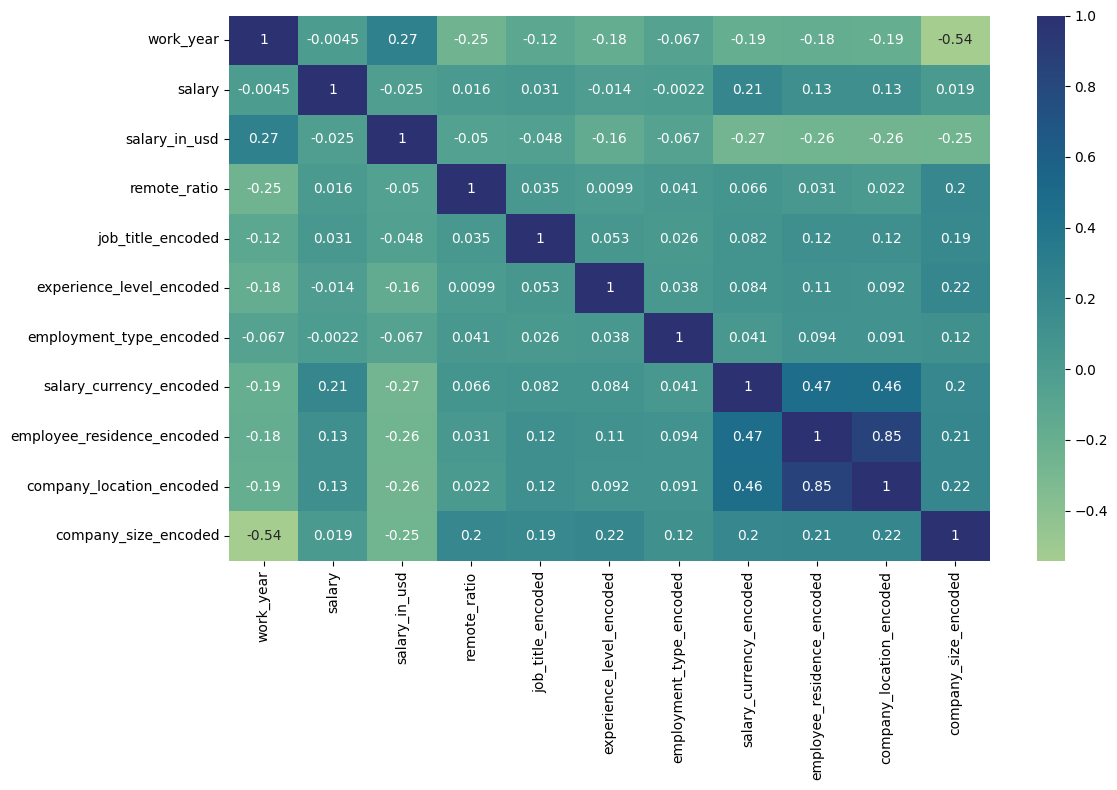

In [32]:
plt.figure(figsize = (12,8))
sns.heatmap(correlation, annot = True, cmap = 'crest')

plt.tight_layout()
plt.show()

In [33]:
correlation


,work_year,salary,salary_in_usd,remote_ratio,job_title_encoded,experience_level_encoded,employment_type_encoded,salary_currency_encoded,employee_residence_encoded,company_location_encoded,company_size_encoded
work_year,1.000000,-0.004470,0.265313,-0.250503,-0.119739,-0.182637,-0.066978,-0.189679,-0.183296,-0.187343,-0.541909
salary,-0.004470,1.000000,-0.025011,0.016488,0.030937,-0.013512,-0.002244,0.212039,0.125763,0.131506,0.018763
salary_in_usd,0.265313,-0.025011,1.000000,-0.050274,-0.047629,-0.161564,-0.066589,-0.266112,-0.258120,-0.262089,-0.253069
remote_ratio,-0.250503,0.016488,-0.050274,1.000000,0.035068,0.009885,0.041132,0.065917,0.030628,0.021994,0.198905
job_title_encoded,-0.119739,0.030937,-0.047629,0.035068,1.000000,0.052918,0.026152,0.082023,0.124805,0.122057,0.189535
experience_level_encoded,-0.182637,-0.013512,-0.161564,0.009885,0.052918,1.000000,0.038424,0.084080,0.105308,0.091617,0.218483
employment_type_encoded,-0.066978,-0.002244,-0.066589,0.041132,0.026152,0.038424,1.000000,0.041233,0.094052,0.091159,0.115859
salary_currency_encoded,-0.189679,0.212039,-0.266112,0.065917,0.082023,0.084080,0.041233,1.000000,0.469230,0.460891,0.196199
employee_residence_encoded,-0.183296,0.125763,-0.258120,0.030628,0.124805,0.105308,0.094052,0.469230,1.000000,0.845871,0.212938
company_location_encoded,-0.187343,0.131506,-0.262089,0.021994,0.122057,0.091617,0.091159,0.460891,0.845871,1.000000,0.216486


In [34]:
df.show()


+---------+------+-------------+------------+-----------------+------------------------+-----------------------+-----------------------+--------------------------+------------------------+--------------------+
|work_year|salary|salary_in_usd|remote_ratio|job_title_encoded|experience_level_encoded|employment_type_encoded|salary_currency_encoded|employee_residence_encoded|company_location_encoded|company_size_encoded|
+---------+------+-------------+------------+-----------------+------------------------+-----------------------+-----------------------+--------------------------+------------------------+--------------------+
|     2023|340000|       340000|           0|              0.0|                     3.0|                    0.0|                    0.0|                       0.0|                     0.0|                 0.0|
|     2023|132000|       132000|         100|              3.0|                     0.0|                    0.0|                    0.0|                       0

In [35]:
colNames = df.columns
colNames

['work_year',
 'salary',
 'salary_in_usd',
 'remote_ratio',
 'job_title_encoded',
 'experience_level_encoded',
 'employment_type_encoded',
 'salary_currency_encoded',
 'employee_residence_encoded',
 'company_location_encoded',
 'company_size_encoded']

In [36]:
df.printSchema()


root
 |-- work_year: integer (nullable = true)
 |-- salary: integer (nullable = true)
 |-- salary_in_usd: integer (nullable = true)
 |-- remote_ratio: integer (nullable = true)
 |-- job_title_encoded: double (nullable = false)
 |-- experience_level_encoded: double (nullable = false)
 |-- employment_type_encoded: double (nullable = false)
 |-- salary_currency_encoded: double (nullable = false)
 |-- employee_residence_encoded: double (nullable = false)
 |-- company_location_encoded: double (nullable = false)
 |-- company_size_encoded: double (nullable = false)



Prediction Random Forest

In [37]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor


features_columns = ['work_year', 'remote_ratio', 'job_title_encoded', 'experience_level_encoded',
                    'employment_type_encoded', 'salary_currency_encoded', 'employee_residence_encoded',
                    'company_location_encoded', 'company_size_encoded']

# Create a VectorAssembler to assemble features into a single column
assembler = VectorAssembler(
    inputCols=['work_year', 'salary', 'salary_in_usd', 'remote_ratio', 'job_title_encoded', 'experience_level_encoded', 'employment_type_encoded',
               'salary_currency_encoded', 'employee_residence_encoded', 'company_location_encoded', 'company_size_encoded'],
    outputCol="features")
df_assembled = assembler.transform(df)

# Select only the necessary columns
df_selected = df_assembled.select("features", "salary_in_usd")

# Split the data into training and testing sets
# Adjust the 'weights' parameter if you want to control the proportion of the split
train_data, test_data = df_selected.randomSplit([0.8, 0.2], seed=42)

# Random Forest Regressor
# = RandomForestRegressor(featuresCol="features", labelCol="salary_in_usd", numTrees=10)
rf = RandomForestRegressor(featuresCol="features", labelCol="salary_in_usd", numTrees=10, maxBins=150)

rf_model = rf.fit(train_data)

# Predictions on the test set
rf_predictions = rf_model.transform(test_data)

# Show the predictions
rf_predictions.show()

+--------------------+-------------+------------------+
|            features|salary_in_usd|        prediction|
+--------------------+-------------+------------------+
|(11,[0,1,2,3,4],[...|       250000| 250627.7984598748|
|(11,[0,1,2,3,4,10...|       132000|127706.25231175998|
|(11,[0,1,2,4,5,10...|        53000| 66163.74699120087|
|[2021.0,50000.0,5...|        59102| 60912.95338985928|
|[2023.0,240000.0,...|        55878|  62595.2545015926|
|(11,[0,1,2],[2023...|       115910| 113380.4738688732|
|(11,[0,1,2,4,5],[...|       190000| 188873.2485522965|
|(11,[0,1,2,4,8,9]...|       200000|199288.91062845942|
|(11,[0,1,2],[2023...|       245000|250602.43814123297|
|(11,[0,1,2,3,8,9]...|       146000|  151032.400864313|
|(11,[0,1,2,4],[20...|       175000|175623.67329303882|
|(11,[0,1,2,4,5],[...|        55000|  76402.1766457363|
|(11,[0,1,2,4,5],[...|        55000| 63225.82610167294|
|(11,[0,1,2,4,5],[...|       130000|121240.90915556779|
|(11,[0,1,2,4],[20...|       150000|156846.00472

Liner Regression

In [90]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol="features", labelCol="salary_in_usd", predictionCol="predicted_salary_in_usd")
lr_model = lr.fit(train_data)

In [91]:
from pyspark.ml.evaluation import RegressionEvaluator
# Select the predicted values and the actual labels
predictions = rf_predictions.select("prediction", "salary_in_usd")

# Evaluate the performance using a RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="salary_in_usd", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

# Print the Root Mean Squared Error (RMSE) or other relevant metrics
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")

Root Mean Squared Error (RMSE) on test data: 39498.62760948576


# **Evaluate Performance**

In [92]:
predictions = lr_model.transform(test_data)

evaluator = RegressionEvaluator(labelCol="salary_in_usd", predictionCol="predicted_salary_in_usd", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data: {:.3f}".format(rmse))

evaluator_mse = RegressionEvaluator(labelCol="salary_in_usd", predictionCol="predicted_salary_in_usd", metricName="mse")
mse = evaluator_mse.evaluate(predictions)
print("MSE on test data: {:.3f}".format(mse))

Root Mean Squared Error (RMSE) on test data: 0.000
MSE on test data: 0.000


# **Inspect Model Co-efficient and Intercept**

In [93]:
coefficients = lr_model.coefficients
intercept = lr_model.intercept

print("Coefficients: ", coefficients)
print("Intercept: {:.3f}".format(intercept))

Coefficients:  [-3.0829015572434152e-12,-2.2488154359259578e-20,0.9999999999999999,-1.38382249046933e-14,3.089646018008551e-14,-1.6228755096894587e-12,-3.160532150962245e-12,1.5086925161387104e-13,4.6828173406605443e-14,1.9450283908473298e-14,-9.07544853506502e-12]
Intercept: 0.000


# **Analyze Feature importance**

In [47]:
feature_importance = sorted(list(zip(data.columns[:-1], map(abs, coefficients))), key=lambda x: x[1], reverse=True)

print("Feature Importance:")
for feature, importance in feature_importance:
    print("  {}: {:.3f}".format(feature, importance))

Feature Importance:
  salary_in_usd: 1.000
  employment_type_encoded: 0.000
  work_year: 0.000
  experience_level_encoded: 0.000
  salary_currency_encoded: 0.000
  employee_residence_encoded: 0.000
  job_title_encoded: 0.000
  company_location_encoded: 0.000
  remote_ratio: 0.000
  salary: 0.000


# **Save and Load the Model**

In [48]:

rf_model.write().overwrite().save("rf_model")





In [49]:
from pyspark.ml.regression import RandomForestRegressionModel
loaded_model = RandomForestRegressionModel.load("rf_model")

In [50]:
lr_model.write().overwrite().save("lr_model")

# Load the model
from pyspark.ml.regression import LinearRegressionModel
loaded_model = LinearRegressionModel.load("lr_model")

Prediction

In [95]:
# Sample input data
new_data = spark.createDataFrame([
    (2023, 340000, 340000, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
], ['work_year', 'salary', 'salary_in_usd', 'remote_ratio', 'job_title_encoded', 'experience_level_encoded', 'employment_type_encoded',
               'salary_currency_encoded', 'employee_residence_encoded', 'company_location_encoded', 'company_size_encoded'])

# Transforming the input data
new_data = assembler.transform(new_data)

In [77]:

rf_predictions = rf_model.transform(new_data)
rf_predictions.select("prediction").show()

+------------------+
|        prediction|
+------------------+
|300501.37239051424|
+------------------+



Using User Input

In [79]:
# from pyspark.sql import SparkSession
# from pyspark.ml.feature import VectorAssembler

# Create a Spark session
spark = SparkSession.builder.appName("example").getOrCreate()

# Define the feature columns
feature_columns = ["work_year", "salary", "salary_in_usd", "remote_ratio", "job_title_encoded",
                   "experience_level_encoded", "employment_type_encoded", "salary_currency_encoded",
                   "employee_residence_encoded", "company_location_encoded", "company_size_encoded"]

work_year = float(input("Enter value for Work Year: "))
salary_in_usd = float(input("Enter value for Salary in Usd: "))

# Create a DataFrame with the user input
user_data = spark.createDataFrame([(work_year, salary_in_usd) + (0.0,) * (len(feature_columns) - 2)], feature_columns)
salary = 340000
# Transform the input data using the VectorAssembler
user_data_transformed = assembler.transform(user_data)

rf_predictions = rf_model.transform(new_data)
rf_predictions.select("prediction").show()


Enter value for Work Year: 2023
Enter value for Salary in Usd: 340000
+------------------+
|        prediction|
+------------------+
|300501.37239051424|
+------------------+

